In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Suppress warnings
import warnings
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore")

# Data Handling and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, precision_recall_fscore_support
from statsmodels.stats.outliers_influence import variance_inflation_factor
import optuna  # For efficient hyperparameter tuning


In [ ]:
# Load dataset (upload your dataset if running on Colab)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Display the first few rows
print("Dataset Preview:")
print(df.head())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Dataset Preview:
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

Missing Values:
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [ ]:
# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Display dataset summary
print("\nDataset Info:")
print(df.info())

# Separating features and target variable
X = df.drop("RiskLevel", axis=1)
y = df["RiskLevel"]

# Encode the target variable if it is categorical
y = pd.factorize(y)[0]

# Normalize features using Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Check the normalized data
print("\nNormalized Data (First 5 Rows):\n", X_scaled[:5])



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 705
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          452 non-null    int64  
 1   SystolicBP   452 non-null    int64  
 2   DiastolicBP  452 non-null    int64  
 3   BS           452 non-null    float64
 4   BodyTemp     452 non-null    float64
 5   HeartRate    452 non-null    int64  
 6   RiskLevel    452 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 28.2+ KB
None

Normalized Data (First 5 Rows):
 [[0.25       0.66666667 0.60784314 0.69230769 0.         0.95180723]
 [0.41666667 0.77777778 0.80392157 0.53846154 0.         0.75903614]
 [0.31666667 0.22222222 0.41176471 0.15384615 0.4        0.87951807]
 [0.33333333 0.77777778 0.70588235 0.07692308 0.         0.75903614]
 [0.41666667 0.55555556 0.21568627 0.00769231 0.         0.8313253 ]]


In [ ]:
# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print("\nVariance Inflation Factor (VIF):")
print(vif_data)



Variance Inflation Factor (VIF):
       Feature        VIF
0          Age   3.835611
1   SystolicBP  16.949557
2  DiastolicBP  12.618178
3           BS   2.090555
4     BodyTemp   1.336234
5    HeartRate   7.231233


In [ ]:
# Use RandomForestClassifier for feature selection
rfc = RandomForestClassifier(random_state=42)
rfe = RFECV(estimator=rfc, step=1, cv=5, scoring='accuracy')
rfe.fit(X_scaled, y)

# Selected features
selected_features = X.columns[rfe.support_]
print("\nSelected Features:", list(selected_features))

# Transform the data to selected features
X_reduced = rfe.transform(X_scaled)



Selected Features: ['Age', 'SystolicBP', 'BS']


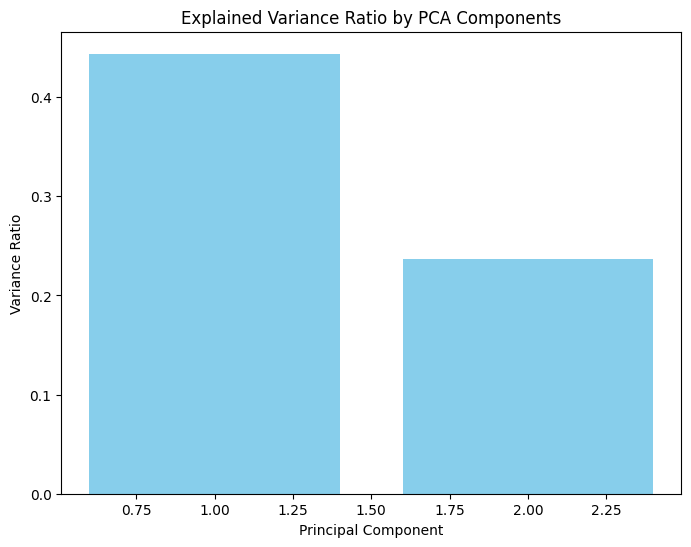

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.title("Explained Variance Ratio by PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.show()


In [ ]:
# Define objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
    return np.mean(scores)

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
print("\nBest Hyperparameters:", study.best_params)


[I 2024-11-17 00:42:51,351] A new study created in memory with name: no-name-7892054b-5087-4526-b97b-a2cdb9c59384
[I 2024-11-17 00:42:52,715] Trial 0 finished with value: 0.6722832722832723 and parameters: {'n_estimators': 181, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6722832722832723.
[I 2024-11-17 00:42:55,774] Trial 1 finished with value: 0.6568009768009768 and parameters: {'n_estimators': 273, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6722832722832723.
[I 2024-11-17 00:42:56,578] Trial 2 finished with value: 0.6722832722832723 and parameters: {'n_estimators': 63, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6722832722832723.
[I 2024-11-17 00:42:58,473] Trial 3 finished with value: 0.6766788766788767 and parameters: {'n_estimators': 257, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.


Best Hyperparameters: {'n_estimators': 295, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}


**Random Forest**

In [ ]:
# Train RandomForest with best parameters
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Measure runtime
start_time = time.time()
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)





Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.64      0.98      0.77        47
           2       1.00      0.04      0.07        26

    accuracy                           0.68        91
   macro avg       0.82      0.62      0.56        91
weighted avg       0.78      0.68      0.59        91


Confusion Matrix:
[[15  3  0]
 [ 1 46  0]
 [ 2 23  1]]

Mean Squared Error: 0.38461538461538464

Accuracy Score: 0.6813186813186813

Runtime (in seconds): 0.4321873188018799


In [ ]:
# Train with all features for comparison
model_full = RandomForestClassifier(**best_params, random_state=42)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Measure runtime
start_time_full = time.time()
model_full.fit(X_train_full, y_train_full)
y_pred_full = model_full.predict(X_test_full)
end_time_full = time.time()

# Evaluation Metrics
print("\nAccuracy with All Features:", accuracy_score(y_test_full, y_pred_full))
print("Accuracy with Selected Features:", accuracy_score(y_test, y_pred))
print("\nRuntime with All Features (in seconds):", end_time_full - start_time_full)



Accuracy with All Features: 0.6813186813186813
Accuracy with Selected Features: 0.6813186813186813

Runtime with All Features (in seconds): 0.9079759120941162


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)

# Measure runtime for training and prediction
start_time_all = time.time()
rf_all.fit(X_train_all, y_train_all)
y_pred_all = rf_all.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### Random Forest with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### Random Forest with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        47
           1       0.86      0.76      0.81        80
           2       0.74      0.84      0.79        76

    accuracy                           0.81       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.82      0.81      0.81       203

Confusion Matrix:
 [[40  1  6]
 [ 3 61 16]
 [ 3  9 64]]
Mean Squared Error: 0.32019704433497537
Accuracy: 0.812807881773399
Runtime (in seconds): 0.20415496826171875


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)

# Measure runtime for training and prediction
start_time_selected = time.time()
rf_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = rf_selected.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### Random Forest with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### Random Forest with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        47
           1       0.66      0.69      0.67        80
           2       0.70      0.67      0.68        76

    accuracy                           0.70       203
   macro avg       0.72      0.72      0.72       203
weighted avg       0.70      0.70      0.70       203

Confusion Matrix:
 [[37  7  3]
 [ 6 55 19]
 [ 4 21 51]]
Mean Squared Error: 0.39901477832512317
Accuracy: 0.7044334975369458
Runtime (in seconds): 0.32778000831604004


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.8128
Accuracy with Selected Features: 0.7044
Runtime with All Features: 0.2042 seconds
Runtime with Selected Features: 0.3278 seconds


## XG BOOST

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from xgboost import XGBClassifier  # XGBoost library


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize XGBoost
xgb_all = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Measure runtime for training and prediction
start_time_all = time.time()
xgb_all.fit(X_train_all, y_train_all)
y_pred_all = xgb_all.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### XGBoost with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### XGBoost with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.87      0.82      0.85        80
           2       0.81      0.84      0.83        76

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
 [[41  1  5]
 [ 4 66 10]
 [ 3  9 64]]
Mean Squared Error: 0.27586206896551724
Accuracy: 0.8423645320197044
Runtime (in seconds): 0.14350390434265137


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Initialize XGBoost
xgb_selected = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Measure runtime for training and prediction
start_time_selected = time.time()
xgb_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = xgb_selected.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### XGBoost with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### XGBoost with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        47
           1       0.69      0.69      0.69        80
           2       0.71      0.70      0.70        76

    accuracy                           0.72       203
   macro avg       0.73      0.73      0.73       203
weighted avg       0.72      0.72      0.72       203

Confusion Matrix:
 [[38  6  3]
 [ 6 55 19]
 [ 4 19 53]]
Mean Squared Error: 0.3842364532019704
Accuracy: 0.7192118226600985
Runtime (in seconds): 0.09532666206359863


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.8424
Accuracy with Selected Features: 0.7192
Runtime with All Features: 0.1435 seconds
Runtime with Selected Features: 0.0953 seconds


LOGISTIC REGRESSION


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression
lr_all = LogisticRegression(max_iter=1000, random_state=42)

# Measure runtime for training and prediction
start_time_all = time.time()
lr_all.fit(X_train_all, y_train_all)
y_pred_all = lr_all.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### Logistic Regression with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### Logistic Regression with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.81      0.75        47
           1       0.60      0.88      0.71        80
           2       0.62      0.26      0.37        76

    accuracy                           0.63       203
   macro avg       0.64      0.65      0.61       203
weighted avg       0.63      0.63      0.59       203

Confusion Matrix:
 [[38  3  6]
 [ 4 70  6]
 [13 43 20]]
Mean Squared Error: 0.6502463054187192
Accuracy: 0.6305418719211823
Runtime (in seconds): 0.05645012855529785


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression
lr_selected = LogisticRegression(max_iter=1000, random_state=42)

# Measure runtime for training and prediction
start_time_selected = time.time()
lr_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = lr_selected.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### Logistic Regression with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### Logistic Regression with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.70      0.64        47
           1       0.54      0.84      0.65        80
           2       0.73      0.21      0.33        76

    accuracy                           0.57       203
   macro avg       0.62      0.58      0.54       203
weighted avg       0.62      0.57      0.53       203

Confusion Matrix:
 [[33 11  3]
 [10 67  3]
 [13 47 16]]
Mean Squared Error: 0.6650246305418719
Accuracy: 0.5714285714285714
Runtime (in seconds): 0.011117696762084961


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.6305
Accuracy with Selected Features: 0.5714
Runtime with All Features: 0.0565 seconds
Runtime with Selected Features: 0.0111 seconds


K Neighbour Nearest


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize KNN Classifier
knn_all = KNeighborsClassifier(n_neighbors=5)  # Default k=5, you can tune this

# Measure runtime for training and prediction
start_time_all = time.time()
knn_all.fit(X_train_all, y_train_all)
y_pred_all = knn_all.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### KNN with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### KNN with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        47
           1       0.66      0.75      0.70        80
           2       0.65      0.54      0.59        76

    accuracy                           0.69       203
   macro avg       0.70      0.71      0.70       203
weighted avg       0.69      0.69      0.69       203

Confusion Matrix:
 [[39  3  5]
 [ 3 60 17]
 [ 7 28 41]]
Mean Squared Error: 0.4876847290640394
Accuracy: 0.6896551724137931
Runtime (in seconds): 0.02553272247314453


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Initialize KNN Classifier
knn_selected = KNeighborsClassifier(n_neighbors=5)  # Default k=5, you can tune this

# Measure runtime for training and prediction
start_time_selected = time.time()
knn_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = knn_selected.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### KNN with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### KNN with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67        47
           1       0.61      0.72      0.66        80
           2       0.69      0.49      0.57        76

    accuracy                           0.64       203
   macro avg       0.64      0.65      0.64       203
weighted avg       0.64      0.64      0.63       203

Confusion Matrix:
 [[34 11  2]
 [ 7 58 15]
 [13 26 37]]
Mean Squared Error: 0.5862068965517241
Accuracy: 0.6354679802955665
Runtime (in seconds): 0.022955656051635742


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.6897
Accuracy with Selected Features: 0.6355
Runtime with All Features: 0.0255 seconds
Runtime with Selected Features: 0.0230 seconds


Gradient Boosting Classifier

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting Classifier
gbc_all = GradientBoostingClassifier(random_state=42)

# Measure runtime for training and prediction
start_time_all = time.time()
gbc_all.fit(X_train_all, y_train_all)
y_pred_all = gbc_all.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### Gradient Boosting Classifier with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### Gradient Boosting Classifier with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        47
           1       0.72      0.74      0.73        80
           2       0.72      0.68      0.70        76

    accuracy                           0.74       203
   macro avg       0.75      0.75      0.75       203
weighted avg       0.74      0.74      0.74       203

Confusion Matrix:
 [[39  4  4]
 [ 5 59 16]
 [ 5 19 52]]
Mean Squared Error: 0.39408866995073893
Accuracy: 0.7389162561576355
Runtime (in seconds): 1.324502944946289


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting Classifier
gbc_selected = GradientBoostingClassifier(random_state=42)

# Measure runtime for training and prediction
start_time_selected = time.time()
gbc_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = gbc_selected.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### Gradient Boosting Classifier with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### Gradient Boosting Classifier with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72        47
           1       0.62      0.72      0.67        80
           2       0.65      0.58      0.61        76

    accuracy                           0.66       203
   macro avg       0.68      0.66      0.67       203
weighted avg       0.66      0.66      0.66       203

Confusion Matrix:
 [[32  8  7]
 [ 5 58 17]
 [ 5 27 44]]
Mean Squared Error: 0.5172413793103449
Accuracy: 0.6600985221674877
Runtime (in seconds): 0.6956322193145752


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.7389
Accuracy with Selected Features: 0.6601
Runtime with All Features: 1.3245 seconds
Runtime with Selected Features: 0.6956 seconds


LDA

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize LDA
lda_all = LinearDiscriminantAnalysis()

# Measure runtime for training and prediction
start_time_all = time.time()
lda_all.fit(X_train_all, y_train_all)
y_pred_all = lda_all.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### LDA with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### LDA with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75        47
           1       0.61      0.86      0.71        80
           2       0.56      0.33      0.41        76

    accuracy                           0.63       203
   macro avg       0.64      0.64      0.62       203
weighted avg       0.63      0.63      0.61       203

Confusion Matrix:
 [[34  3 10]
 [ 1 69 10]
 [ 9 42 25]]
Mean Squared Error: 0.6502463054187192
Accuracy: 0.6305418719211823
Runtime (in seconds): 0.025264263153076172


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Initialize LDA
lda_selected = LinearDiscriminantAnalysis()

# Measure runtime for training and prediction
start_time_selected = time.time()
lda_selected.fit(X_train_selected, y_train_selected)
y_pred_selected = lda_selected.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### LDA with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### LDA with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.70      0.63        47
           1       0.59      0.76      0.67        80
           2       0.71      0.39      0.51        76

    accuracy                           0.61       203
   macro avg       0.63      0.62      0.60       203
weighted avg       0.63      0.61      0.60       203

Confusion Matrix:
 [[33 10  4]
 [11 61  8]
 [14 32 30]]
Mean Squared Error: 0.6551724137931034
Accuracy: 0.6108374384236454
Runtime (in seconds): 0.006329059600830078


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.6305
Accuracy with Selected Features: 0.6108
Runtime with All Features: 0.0253 seconds
Runtime with Selected Features: 0.0063 seconds


**Stacking Classifier- DT+RF+Logistic Regression**

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset (replace with your file path)
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update path if necessary
df = pd.read_csv(file_path)

# Encode target variable if categorical
y = pd.factorize(df["RiskLevel"])[0]
X = df.drop("RiskLevel", axis=1)

# Selected Features from Feature Selection Step
selected_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate']  # Replace with your selected features

# Transform the data
X_selected = X[selected_features]

# Normalize data (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_selected_scaled = scaler.fit_transform(X_selected)


In [ ]:
# Define base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('logistic_regression', LogisticRegression(random_state=42, max_iter=1000))
]

# Define Stacking Classifier with Logistic Regression as final estimator
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000)
)


In [ ]:
# Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Measure runtime for training and prediction
start_time_all = time.time()
stacking_clf.fit(X_train_all, y_train_all)
y_pred_all = stacking_clf.predict(X_test_all)
end_time_all = time.time()

# Evaluation Metrics
print("### Stacking Classifier with All Features ###")
print("Classification Report:\n", classification_report(y_test_all, y_pred_all))
print("Confusion Matrix:\n", confusion_matrix(y_test_all, y_pred_all))
print("Mean Squared Error:", mean_squared_error(y_test_all, y_pred_all))
print("Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("Runtime (in seconds):", end_time_all - start_time_all)


### Stacking Classifier with All Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84        47
           1       0.87      0.81      0.84        80
           2       0.80      0.84      0.82        76

    accuracy                           0.83       203
   macro avg       0.83      0.84      0.83       203
weighted avg       0.83      0.83      0.83       203

Confusion Matrix:
 [[40  1  6]
 [ 5 65 10]
 [ 3  9 64]]
Mean Squared Error: 0.30049261083743845
Accuracy: 0.8325123152709359
Runtime (in seconds): 5.068222284317017


In [ ]:
# Train-Test Split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Measure runtime for training and prediction
start_time_selected = time.time()
stacking_clf.fit(X_train_selected, y_train_selected)
y_pred_selected = stacking_clf.predict(X_test_selected)
end_time_selected = time.time()

# Evaluation Metrics
print("\n### Stacking Classifier with Selected Features ###")
print("Classification Report:\n", classification_report(y_test_selected, y_pred_selected))
print("Confusion Matrix:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Mean Squared Error:", mean_squared_error(y_test_selected, y_pred_selected))
print("Accuracy:", accuracy_score(y_test_selected, y_pred_selected))
print("Runtime (in seconds):", end_time_selected - start_time_selected)



### Stacking Classifier with Selected Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        47
           1       0.66      0.69      0.67        80
           2       0.68      0.66      0.67        76

    accuracy                           0.70       203
   macro avg       0.71      0.71      0.71       203
weighted avg       0.70      0.70      0.70       203

Confusion Matrix:
 [[37  6  4]
 [ 6 55 19]
 [ 4 22 50]]
Mean Squared Error: 0.4187192118226601
Accuracy: 0.6995073891625616
Runtime (in seconds): 1.8997719287872314


In [ ]:
# Print the comparison results
print("\n### Comparison of All Features vs Selected Features ###")
print(f"Accuracy with All Features: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy with Selected Features: {accuracy_score(y_test_selected, y_pred_selected):.4f}")
print(f"Runtime with All Features: {end_time_all - start_time_all:.4f} seconds")
print(f"Runtime with Selected Features: {end_time_selected - start_time_selected:.4f} seconds")



### Comparison of All Features vs Selected Features ###
Accuracy with All Features: 0.8325
Accuracy with Selected Features: 0.6995
Runtime with All Features: 5.0682 seconds
Runtime with Selected Features: 1.8998 seconds


 Decision Tree, Random Forest, and Gradient Boosting

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Load the dataset
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update file path if needed
df = pd.read_csv(file_path)

# Encode the target variable
y = pd.factorize(df["RiskLevel"])[0]
X = df[['SystolicBP', 'DiastolicBP', 'HeartRate']]  # Select 3 features

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define base models for Stacking Classifier
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42, max_depth=5)),
    ('random_forest', RandomForestClassifier(random_state=42, n_estimators=100)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1))
]

# Define the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000)
)

# Train the Stacking Classifier
start_time = time.time()
stacking_clf.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_pred = stacking_clf.predict(X_test)

# Evaluation Metrics
print("### Ensemble Method with 3 Features ###")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Runtime (in seconds):", end_time - start_time)


### Ensemble Method with 3 Features ###
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.66      0.67        47
           1       0.63      0.72      0.67        80
           2       0.62      0.53      0.57        76

    accuracy                           0.64       203
   macro avg       0.64      0.64      0.64       203
weighted avg       0.63      0.64      0.63       203

Confusion Matrix:
 [[31  5 11]
 [ 8 58 14]
 [ 7 29 40]]
Mean Squared Error: 0.6305418719211823
Accuracy: 0.6354679802955665
Runtime (in seconds): 3.271819591522217


##**2 method**


Feature Selection

In [ ]:
# Import necessary libraries
import pandas as pd
from google.colab import drive



# Load the dataset
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update the path as needed
df = pd.read_csv(file_path)

# Display the first few rows to understand the dataset
print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (1014, 7)
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode the target variable (RiskLevel)
df['RiskLevel'] = LabelEncoder().fit_transform(df['RiskLevel'])
y = df['RiskLevel']  # Target variable
X = df.drop(columns=['RiskLevel'])  # Features

# Normalize the features for statistical tests
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [ ]:
from sklearn.feature_selection import f_classif, mutual_info_classif

# Initialize a dictionary to store selected features from each method
selected_features = {}

# ANOVA F-Test
f_values, p_values = f_classif(X_scaled, y)
anova_df = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
selected_features['ANOVA_F_Test'] = anova_df[anova_df['P-Value'] < 0.05]['Feature'].tolist()
print("ANOVA F-Test Selected Features:", selected_features['ANOVA_F_Test'])

# Mutual Information
mutual_info = mutual_info_classif(X_scaled, y)
mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
selected_features['Mutual_Information'] = mutual_info_df[mutual_info_df['Mutual Information'] > 0.01]['Feature'].tolist()
print("Mutual Information Selected Features:", selected_features['Mutual_Information'])


ANOVA F-Test Selected Features: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
Mutual Information Selected Features: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Recursive Feature Elimination (RFE) with Logistic Regression
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, n_features_to_select=3)
rfe.fit(X_scaled, y)
selected_features['RFE_Logistic'] = X.columns[rfe.support_].tolist()
print("RFE Selected Features:", selected_features['RFE_Logistic'])


RFE Selected Features: ['SystolicBP', 'BS', 'BodyTemp']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest for Feature Importance
rf = RandomForestClassifier(random_state=0)
rf.fit(X_scaled, y)
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
selected_features['Random_Forest_Importance'] = importance_df.head(3)['Feature'].tolist()  # Top 3 features
print("Random Forest Selected Features:", selected_features['Random_Forest_Importance'])


Random Forest Selected Features: ['BS', 'SystolicBP', 'Age']


In [ ]:
# Display all selected features from each method
print("\n### Selected Features by Method ###")
for method, features in selected_features.items():
    print(f"{method}: {features}")



### Selected Features by Method ###
ANOVA_F_Test: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
Mutual_Information: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
RFE_Logistic: ['SystolicBP', 'BS', 'BodyTemp']
Random_Forest_Importance: ['BS', 'SystolicBP', 'Age']


Logistic Regression

In [ ]:
# Example: Use features selected by Random Forest
selected_features_rf = selected_features['Random_Forest_Importance']
X_selected_rf = X[selected_features_rf]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.3, random_state=42)

# Train a classifier (e.g., Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Model Accuracy with Selected Features:", accuracy_score(y_test, y_pred))


Model Accuracy with Selected Features: 0.5377049180327869


In [ ]:
# Example: Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Train a classifier (e.g., Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Model Accuracy with RFE Selected Features:", accuracy_score(y_test, y_pred))


Model Accuracy with RFE Selected Features: 0.5868852459016394


Random Forest

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
final_model = RandomForestClassifier(random_state=42)

# Measure runtime and train the model
start_time = time.time()
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.70      0.76      0.73       117
           2       0.70      0.60      0.64       112

    accuracy                           0.73       305
   macro avg       0.74      0.75      0.74       305
weighted avg       0.73      0.73      0.73       305


Confusion Matrix:
[[68  2  6]
 [ 5 89 23]
 [ 9 36 67]]

Mean Squared Error: 0.4131147540983607

Accuracy Score: 0.7344262295081967

Runtime (in seconds): 0.1901254653930664


KNN

In [ ]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the KNN model (choose an appropriate k, e.g., k=5)
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

# Measure runtime and train the model
start_time = time.time()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        76
           1       0.64      0.78      0.70       117
           2       0.62      0.42      0.50       112

    accuracy                           0.67       305
   macro avg       0.67      0.68      0.67       305
weighted avg       0.66      0.67      0.65       305


Confusion Matrix:
[[65  4  7]
 [ 4 91 22]
 [18 47 47]]

Mean Squared Error: 0.580327868852459

Accuracy Score: 0.6655737704918033

Runtime (in seconds): 0.021788597106933594


Gradient Boosting

In [ ]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Measure runtime and train the model
start_time = time.time()
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        76
           1       0.69      0.74      0.71       117
           2       0.64      0.57      0.60       112

    accuracy                           0.71       305
   macro avg       0.72      0.73      0.72       305
weighted avg       0.71      0.71      0.71       305


Confusion Matrix:
[[66  2  8]
 [ 2 87 28]
 [10 38 64]]

Mean Squared Error: 0.46557377049180326

Accuracy Score: 0.7114754098360656

Runtime (in seconds): 0.4102907180786133


SVM


In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can also try 'rbf', 'poly', etc. for different kernels

# Measure runtime and train the model
start_time = time.time()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        76
           1       0.58      0.92      0.71       117
           2       0.55      0.21      0.30       112

    accuracy                           0.63       305
   macro avg       0.64      0.64      0.60       305
weighted avg       0.62      0.63      0.58       305


Confusion Matrix:
[[ 61   3  12]
 [  2 108   7]
 [ 13  76  23]]

Mean Squared Error: 0.6163934426229508

Accuracy Score: 0.6295081967213115

Runtime (in seconds): 0.21328043937683105


XG Boost

In [ ]:
!pip install xgboost


In [ ]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Measure runtime and train the model
start_time = time.time()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        76
           1       0.70      0.77      0.73       117
           2       0.69      0.59      0.63       112

    accuracy                           0.73       305
   macro avg       0.75      0.75      0.75       305
weighted avg       0.73      0.73      0.73       305


Confusion Matrix:
[[68  2  6]
 [ 3 90 24]
 [ 9 37 66]]

Mean Squared Error: 0.4131147540983607

Accuracy Score: 0.7344262295081967

Runtime (in seconds): 0.15740251541137695


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ada Boost

In [ ]:
# Import necessary libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the AdaBoost model
ada_model = AdaBoostClassifier(random_state=42, n_estimators=50)  # Adjust n_estimators as needed

# Measure runtime and train the model
start_time = time.time()
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        76
           1       0.68      0.75      0.71       117
           2       0.57      0.56      0.57       112

    accuracy                           0.66       305
   macro avg       0.68      0.66      0.67       305
weighted avg       0.67      0.66      0.66       305


Confusion Matrix:
[[51  4 21]
 [ 3 88 26]
 [11 38 63]]

Mean Squared Error: 0.6524590163934426

Accuracy Score: 0.6622950819672131

Runtime (in seconds): 0.2492520809173584


Naive Bayes

In [ ]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Measure runtime and train the model
start_time = time.time()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        76
           1       0.51      0.94      0.66       117
           2       0.42      0.17      0.24       112

    accuracy                           0.55       305
   macro avg       0.59      0.54      0.51       305
weighted avg       0.56      0.55      0.50       305


Confusion Matrix:
[[ 38  19  19]
 [  0 110   7]
 [  8  85  19]]

Mean Squared Error: 0.7180327868852459

Accuracy Score: 0.5475409836065573

Runtime (in seconds): 0.023088932037353516


Decision Tree

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Measure runtime and train the model
start_time = time.time()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.70      0.76      0.73       117
           2       0.70      0.60      0.64       112

    accuracy                           0.73       305
   macro avg       0.74      0.75      0.74       305
weighted avg       0.73      0.73      0.73       305


Confusion Matrix:
[[68  2  6]
 [ 5 89 23]
 [ 9 36 67]]

Mean Squared Error: 0.4131147540983607

Accuracy Score: 0.7344262295081967

Runtime (in seconds): 0.012102842330932617


Rotation Forest

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import numpy as np
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Parameters
n_estimators = 10  # Number of estimators in the rotational forest
subset_size = X_train.shape[1] // 2  # Size of each subset for PCA rotation

# List to hold individual models
models = []

# Creating rotated decision trees
for i in range(n_estimators):
    # Randomly select subset of features
    random_subset = np.random.choice(X_train.columns, size=subset_size, replace=False)
    pca = PCA(n_components=subset_size, random_state=i)

    # Apply PCA on the selected feature subset
    X_train_rotated = pca.fit_transform(X_train[random_subset])
    X_test_rotated = pca.transform(X_test[random_subset])

    # Initialize Decision Tree and add to list
    model = DecisionTreeClassifier(random_state=i)
    model.fit(X_train_rotated, y_train)
    models.append(('dt' + str(i), model))

# Create Voting Classifier with all rotated decision trees
rotational_forest = VotingClassifier(estimators=models, voting='soft')

# Measure runtime and train the ensemble model
start_time = time.time()
rotational_forest.fit(X_train, y_train)
y_pred = rotational_forest.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.70      0.76      0.73       117
           2       0.70      0.60      0.64       112

    accuracy                           0.73       305
   macro avg       0.74      0.75      0.74       305
weighted avg       0.73      0.73      0.73       305


Confusion Matrix:
[[68  2  6]
 [ 5 89 23]
 [ 9 36 67]]

Mean Squared Error: 0.4131147540983607

Accuracy Score: 0.7344262295081967

Runtime (in seconds): 0.10632038116455078


Ensemble Method - Stacking Classifier - Decision Tree + Random Forest + Logistic **Regression**

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Define base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('logistic_regression', LogisticRegression(max_iter=1000, random_state=42))
]

# Define stacking classifier with Logistic Regression as the meta-model
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Measure runtime and train the stacking model
start_time = time.time()
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.67      0.80      0.73       117
           2       0.71      0.53      0.61       112

    accuracy                           0.72       305
   macro avg       0.74      0.74      0.73       305
weighted avg       0.73      0.72      0.72       305


Confusion Matrix:
[[68  2  6]
 [ 5 94 18]
 [ 9 44 59]]

Mean Squared Error: 0.42295081967213116

Accuracy Score: 0.7245901639344262

Runtime (in seconds): 3.5275156497955322


XG Boost With L1 and L2 regularization

In [ ]:
# Install XGBoost if it's not already installed
!pip install xgboost

# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize XGBoost model with L1 (alpha) and L2 (lambda) regularization
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Use 'multi:softmax' for multiclass
    eval_metric='logloss',        # Evaluation metric
    alpha=0.1,                    # L1 regularization term
    reg_lambda=1.0,               # L2 regularization term
    n_estimators=100,             # Number of trees
    max_depth=3,                  # Depth of each tree
    learning_rate=0.1,            # Learning rate
    random_state=42
)

# Measure runtime and train the model
start_time = time.time()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        76
           1       0.68      0.75      0.72       117
           2       0.63      0.59      0.61       112

    accuracy                           0.71       305
   macro avg       0.73      0.72      0.73       305
weighted avg       0.71      0.71      0.71       305


Confusion Matrix:
[[63  2 11]
 [ 2 88 27]
 [ 7 39 66]]

Mean Squared Error: 0.46557377049180326

Accuracy Score: 0.7114754098360656

Runtime (in seconds): 0.06496095657348633


LDA

In [ ]:
# Import necessary libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
import time

# Use features selected by RFE (Logistic Regression)
selected_features_rfe = selected_features['RFE_Logistic']
X_selected_rfe = X[selected_features_rfe]

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected_rfe, y, test_size=0.3, random_state=42)

# Initialize the LDA model
lda_model = LinearDiscriminantAnalysis()

# Measure runtime and train the model
start_time = time.time()
lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_test)
end_time = time.time()

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.63      0.70        76
           1       0.59      0.91      0.72       117
           2       0.48      0.26      0.34       112

    accuracy                           0.60       305
   macro avg       0.61      0.60      0.58       305
weighted avg       0.59      0.60      0.57       305


Confusion Matrix:
[[ 48   4  24]
 [  2 107   8]
 [ 12  71  29]]

Mean Squared Error: 0.7508196721311475

Accuracy Score: 0.6032786885245902

Runtime (in seconds): 0.03510642051696777


Ensemble stacking Classifier-LR+Ridge Classifier+DT+RF

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
import time

# Load your dataset
file_path = '/content/Maternal Health Risk Data Set.csv'  # Update this with your actual file path if using Colab
df = pd.read_csv(file_path)

# Display dataset information to check column names and content
print("Dataset Shape:", df.shape)
print(df.head())
print("Available columns:", df.columns)

# Encode the target variable (RiskLevel)
df['RiskLevel'] = pd.factorize(df['RiskLevel'])[0]
y = df['RiskLevel']  # Target variable
X = df.drop(columns=['RiskLevel'])  # Features

# Select the features based on your previous selection method
# Replace 'feature1', 'feature2', 'feature3' with the actual names of your chosen features
selected_features = ['SystolicBP', 'BS', 'BodyTemp']  # Example: ['Age', 'BMI', 'BloodPressure']
X_selected = X[selected_features]  # Filter your dataset to only include these features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Define base models for Stacking
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('logistic_regression', LogisticRegression(max_iter=1000))
]

# Define the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),  # Logistic Regression as the meta-learner
    cv=5
)

# Train the model and measure runtime
start_time = time.time()
stacking_clf.fit(X_train, y_train)
end_time = time.time()

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Runtime
print("\nRuntime (in seconds):", end_time - start_time)


Dataset Shape: (1014, 7)
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
Available columns: Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        76
           1       0.67      0.80      0.73       117
           2       0.71      0.53      0.61       112

    accuracy                           0.72       305
   macro avg       0.74      0.74      0.73       305
weighted avg       0.73      0.72      0.72       305


Confusion Mat

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset (upload your file in Colab and adjust the file path if needed)
file_path = '/content/Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)

# Preprocessing
# Encode the target variable (RiskLevel)
data['RiskLevel'] = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

# Select features and target
X = data[['SystolicBP', 'BS', 'BodyTemp']]
y = data['RiskLevel']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base models
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train base models
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)

# Generate predictions for meta-model training
rf_pred_train = rf_model.predict_proba(X_train_scaled)
xgb_pred_train = xgb_model.predict_proba(X_train_scaled)

# Stack predictions for meta-learner
meta_train = np.hstack((rf_pred_train, xgb_pred_train))

# Test set predictions for final evaluation
rf_pred_test = rf_model.predict_proba(X_test_scaled)
xgb_pred_test = xgb_model.predict_proba(X_test_scaled)
meta_test = np.hstack((rf_pred_test, xgb_pred_test))

# Meta-learner (Logistic Regression)
meta_learner = LogisticRegression(max_iter=1000)
meta_learner.fit(meta_train, y_train)

# Final predictions
final_pred = meta_learner.predict(meta_test)

# Evaluate the model
accuracy = accuracy_score(y_test, final_pred)
print("Blended Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Blended Model Accuracy: 0.7389162561576355


 Voting Classifier with Weighted Voting-weighted combination of Random Forest, XGBoost, and Gradient Boosting

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load the dataset (upload your file in Colab and adjust the file path if needed)
file_path = '/content/Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)

# Preprocessing
# Encode the target variable (RiskLevel)
data['RiskLevel'] = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

# Select features and target
X = data[['SystolicBP', 'BS', 'BodyTemp']]
y = data['RiskLevel']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Voting Classifier with weights
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    voting='soft',  # Use probabilities for weighted voting
    weights=[2, 3, 1]  # Adjust weights based on model performance
)

# Train the Voting Classifier
voting_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Weighted Voting Classifier Accuracy:", accuracy)

# Cross-validate to check performance consistency
cv_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validated Accuracy Scores:", cv_scores)
print(" Accuracy:", cv_scores.mean())


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Weighted Voting Classifier Accuracy: 0.729064039408867


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validated Accuracy Scores: [0.72392638 0.78395062 0.75308642 0.81481481 0.74691358]
 Accuracy: 0.7645383624933728


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Weighted Voting Classifier Accuracy: 0.729064039408867


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:50:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validated Accuracy Scores: [0.72392638 0.78395062 0.75308642 0.81481481 0.74691358]
 Accuracy: 0.7645383624933728
